## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

Camera Calibration:  I followed standard procedure for camera calibration where all chessboard images are read and converted to gray.
Then using the built-in CV2 function, corners from the images are found and displayed on top of the original chessboard images.

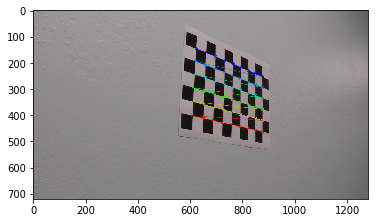

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
       
        plt.imshow(img)


Tne next step is to calibrate camera with built-in CV2 function by passing corners points and 3d grid points to the function.

Output of the function are camera calibration matrix and distortion coefficients. A sample image is undistorted with these calibtation values and shown below.

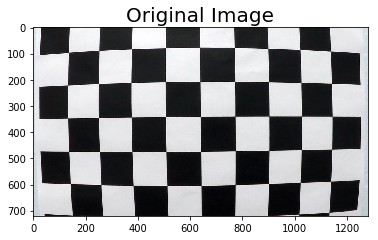

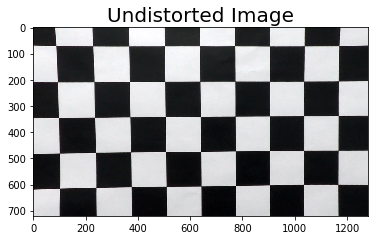

In [2]:
#calibrate
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

#sample images
img = cv2.imread(images[0])
ax1=plt.figure(1)
plt.imshow(img)
plt.title('Original Image', fontsize=20)
ax2=plt.figure(2)
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)
plt.title('Undistorted Image', fontsize=20)

Now, I take a sample image from the folder "test_images" and look at the bird's eye view of it.
I found four points along lanes in the sample image to transform the polygon in the original image to a rectangle in a transformed image. Such transformation is executed with a perspective transform function so that the output image is like a bird-eye view of the road with lanes.

Next step is to find edges or representation of lanes in the bird's eye view of the road.
I use sobel operation in x direction to get gradient of the image. 
Then the image is converted to HLS formate, where Saturation is shown to robustly detect lanes. 

Then the image is converted to HSV format to detect yellow and white colors in the image as the lane colors are yellow or white.
Fianlly, appropriate thresholds on graident, saturation and color space are applied ato ensure that the combined result includes lanes in the binary output image.

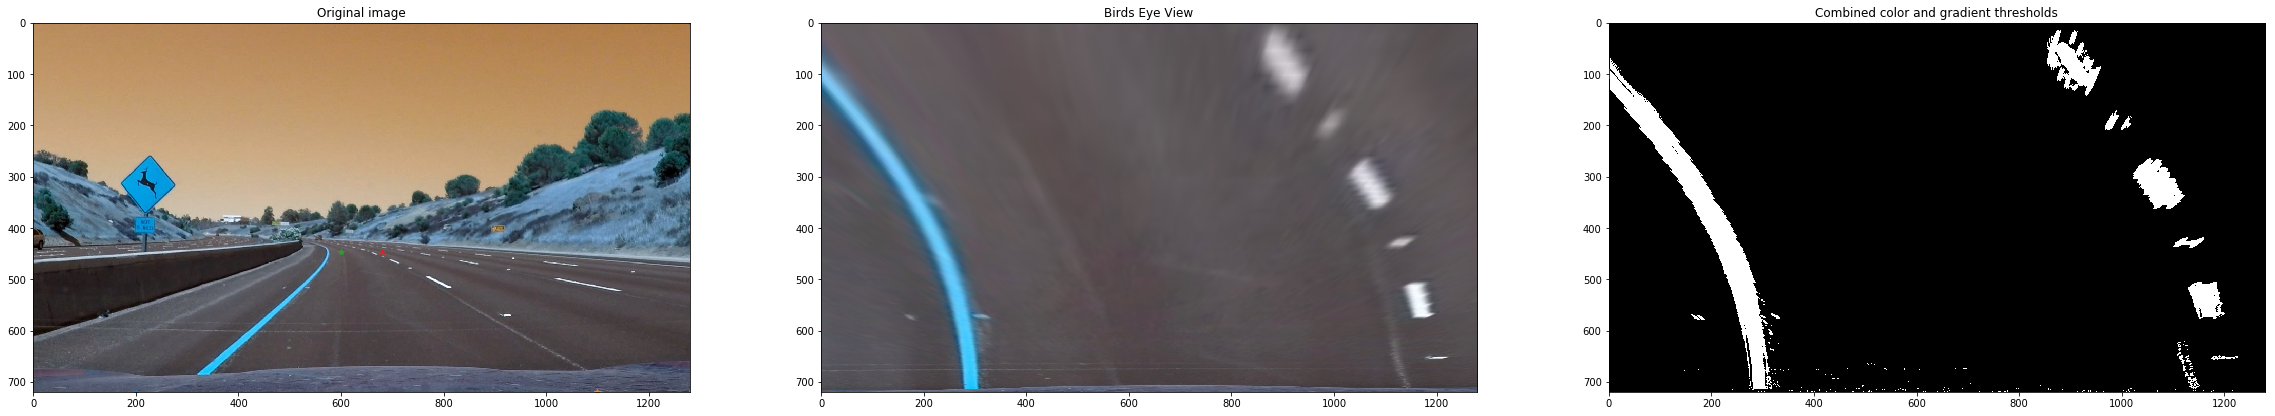

In [4]:
# read raw images
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

# Process a sample image(first image) from test_images
for fname in images[3:4]:
    img = cv2.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)  #undistort the image
    
    #transform to bird's eye view
    src = np.float32([[200,719],[1100,719],[600,447],[680,447]])
    dst = np.float32([[200,719],[1100,719],[200,0],[1100,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    img_size = (undist.shape[1],undist.shape[0])
    bird_view = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    gray = cv2.cvtColor(bird_view,cv2.COLOR_BGR2GRAY)  #gray conversion
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    hls = cv2.cvtColor(bird_view, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    HSV = cv2.cvtColor(bird_view, cv2.COLOR_RGB2HSV)
    # For yellow
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))

    # For white
    sensitivity_1 = 68
    white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))

    sensitivity_2 = 60
    HSL = cv2.cvtColor(bird_view, cv2.COLOR_RGB2HLS)
    white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    white_3 = cv2.inRange(bird_view, (200,200,200), (255,255,255))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gray)
    #combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (yellow > 1) | 
                   (white > 1) | (white_2 > 1) | (white_3 > 1)] = 1
    
    binary_warped = combined_binary
    # Plotting thresholded images
    plt.figure()
    f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(40,20))
    ax2.set_title('Birds Eye View')
    ax2.imshow(bird_view)

    ax3.set_title('Combined color and gradient thresholds')
    ax3.imshow(combined_binary, cmap='gray')

    ax1.set_title('Original image')
    ax1.imshow(img)
    ax1.plot(200,719,'*')
    ax1.plot(1100,719,'*')
    ax1.plot(600,447,'*')
    ax1.plot(680,447,'*')

Next step is to find lanes in the transformed image. The basic idea is to look at histogram in the bottom half of the image to identify region with bright pixels. The two regions are most likely left and right lanes in the image.
From there, the lane detection window is graudally moved up along y-axis. Once all bright pixels in the lane region are identified, a polynomial fit is calculated for both left and right lanes.
Result of this process with detection windows and fit curve are shown for the sample image.

/Users/Dushyant/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


(720, 0)

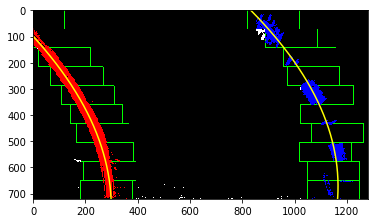

In [5]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 10
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [6]:
# sanity check purpose
print(ploty.shape)
print(leftx.shape, lefty.shape, left_fit.shape, right_fit.shape)
print(ploty[-1], left_fitx[-1])

(720,)
(29504,) (29504,) (3,) (3,)
719.0 298.149728957


show the image with width of detection window (margin) along the lane curve

(720, 0)

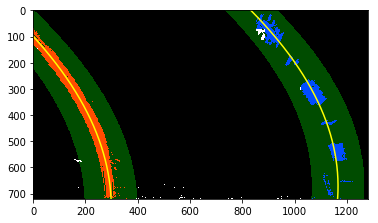

In [7]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Calculate radius of curvature of both lanes at the point closest to the car i.e. the bottom of the image

In [8]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = 719
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

720.421252575 683.941188554


convert radius of curvature from pixel to real-world distance in meters

In [9]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 10/100 # meters per pixel in y dimension
xm_per_pix = 3.7/885 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1717.19225456 m 1624.45927664 m


Final step is to transform the detected lanes back to original undistorted image in order for car to find lanes in the real-world setting.
I use inverse coefficient matrix for reverse transformation and paint the area between lanes as green. Also, the difference between lane center and vehicle position is calculated and displayed on the image.

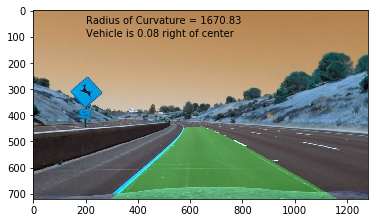

In [10]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
s1 = 'Radius of Curvature = '
s2 = 'Vehicle is '
Radius_curv = (left_curverad + right_curverad)/2
lane_center = np.amax(pts_left[0,:,0])/2 + np.amax(pts_right[0,:,0])/2
offset = (750 - lane_center)*xm_per_pix
if offset > 0:
    pos = ' right of center'
else:
    pos = 'left of center'
plt.text(200,100, s2 + '%0.2f' %abs(offset) + pos)
plt.text(200, 50,s1 + '%0.2f' %Radius_curv)

## Pipeline for Video stream...

So far, I focused on designing and tunine the code on sample images. After, testing and fine-tuning the code for sample image, I am ready to apply the above code to video stream.

Below is the code that combines all the steps above in a single function find_lanes(). Also, a structure Line is used to keep track and provide continuity between successive instances of lane detection. I use the stucture to update the measurements of redius of curvature and vehicle position at every 10 images in the video.

In [11]:

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
      
        self.display_curvature = 0
        self.radius_of_curvature = 0
        #distance in meters of vehicle center from the line
        self.display_pos = 0
        self.veh_pos = 0
        #frame_number in a video
        self.frame = 0

combined_binary = np.zeros_like(sxbinary)
img_size = (undist.shape[1],undist.shape[0])
# Define conversions in x and y from pixels space to meters
ym_per_pix = 10/100 # meters per pixel in y dimension
xm_per_pix = 3.7/885 # meters per pixel in x dimension
y_eval = 719
ploty = np.linspace(0, 719, 720 )

Lane = Line()

def find_lanes(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)  #undistort the image
    
    bird_view = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    gray = cv2.cvtColor(bird_view,cv2.COLOR_BGR2GRAY)  #gray conversion
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    hls = cv2.cvtColor(bird_view, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    HSV = cv2.cvtColor(bird_view, cv2.COLOR_RGB2HSV)
    # For yellow
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))

    # For white
    sensitivity_1 = 68
    white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))

    sensitivity_2 = 60
    HSL = cv2.cvtColor(bird_view, cv2.COLOR_RGB2HLS)
    white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    white_3 = cv2.inRange(bird_view, (200,200,200), (255,255,255))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gray)
    #combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (yellow > 1) | 
                   (white > 1) | (white_2 > 1) | (white_3 > 1)] = 1
    
    binary_warped = combined_binary
    
    if Lane.detected == False:
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 10
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        Lane.leftfit = left_fit
        Lane.rightfit = right_fit
        Lane.detected = True
        
    else:
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_fit = Lane.leftfit
        right_fit = Lane.rightfit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        Lane.leftfit = left_fit
        Lane.rightfit = right_fit
            
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    Radius_curv = (left_curverad + right_curverad)/2
    Lane.frame = Lane.frame + 1
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #calculate vehicle position wrt to center of the lane
    lane_center = np.amax(pts_left[0,:,0])/2 + np.amax(pts_right[0,:,0])/2
    offset = (750 - lane_center)*xm_per_pix
    
    #update displays of radius and vehicle position at each 10 images
    if Lane.frame > 9 :
        Lane.display_curvature = (Lane.radius_of_curvature + Radius_curv)/10
        Lane.radius_of_curvature = 0
        Lane.display_pos = (Lane.veh_pos + offset)/10
        Lane.veh_pos = 0
        Lane.frame = 0
    else:
        Lane.radius_of_curvature = Lane.radius_of_curvature + Radius_curv
        Lane.veh_pos = Lane.veh_pos + offset
        
    s1 = 'Radius of Curvature = '
    s2 = 'Vehicle is '
    
    if Lane.display_pos > 0:
        pos = ' m right of center'
    else:
        pos = ' m left of center'
    s11 = s1 + '%0.2f' %Lane.display_curvature + 'm'
    s22 = s2 + '%0.2f' %abs(Lane.display_pos) + pos

    cv2.putText(result,s11,(200,50),cv2.FONT_HERSHEY_SIMPLEX,1.0,(255,255,255), 1, cv2.LINE_AA)
    cv2.putText(result,s22,(200,150),cv2.FONT_HERSHEY_SIMPLEX,1.0,(255,255,255), 1, cv2.LINE_AA)
    

    #Check if the detected lines are the "real thing"
    # measure distance between lanes in the image at bottom
    lane_dist = (right_fitx[-1] - left_fitx[-1])*xm_per_pix
    if (lane_dist > 3.5) | (lane_dist < 3.9):
        Lane.detected = True
    else:
        Lane.detected = False
    #print(lane_dist)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    plot1 = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    plot2 = np.dstack((combined_binary, combined_binary, combined_binary))*255
    # assemble the screen example
    diagScreen = np.zeros((720,1280, 3), dtype=np.uint8)
    diagScreen[0:360, 0:640] = cv2.resize(result, (640,360), interpolation=cv2.INTER_AREA) 
    diagScreen[0:360, 640:1280] = cv2.resize(bird_view, (640,360), interpolation=cv2.INTER_AREA)
    diagScreen[360:720, 0:640] = cv2.resize(out_img, (640,360), interpolation=cv2.INTER_AREA)
    diagScreen[360:720, 640:1280] = cv2.resize(plot2, (640,360), interpolation=cv2.INTER_AREA)
    return diagScreen
    
def lane_dec_pipeline(image):
    
    LaneArea = find_lanes(image)
    
    return LaneArea
    

Project video is fed iamge by image to the lane detection pipeline function - lane_dec_pipeline(). 
The criteria for successful video detection is lane distance between 3.5 and 3.9 m. 
Lastly, the output is saved into a new video under "project_lane_video" name.

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

detect_flag = 0
clip1 = VideoFileClip("project_video.mp4",verbose=False)
white_clip = clip1.fl_image(lane_dec_pipeline) #NOTE: this function expects color images!!
% time white_clip.write_videofile('project_lane_video.mp4', audio=False,verbose=False)
print('done')

100%|█████████▉| 1260/1261 [04:21<00:00,  4.70it/s]


CPU times: user 5min 17s, sys: 51.5 s, total: 6min 8s
Wall time: 4min 22s
done
